# Score-based Generative Modeling with SDEs (Simple examples)

In [1]:
import os
import time

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import lib.toy_data as toy_data
import numpy as np
import pickle

Basic parameters

In [3]:
learning_rate = 5e-4 # learning rate for training neural network
batch_size = 1000  # batch size during training of neural network
N_samples = 1000
epochs = 1000000   # Number of training epochs for the neural network
sigma_max = 10.0 
sigma_min = 0.01  
T = 1    # Forward simulation time in the forward SDE (fixed)
dataset = 'Lorenz63' # Dataset choice, see toy_data for full options of toy datasets 
d = 3

We first initialize the neural net that models the score function. 

In [4]:
## Model construction

class DenoisingModel(nn.Module):
    
    def __init__(self, hidden_units=32):
        super(DenoisingModel, self).__init__()
        # hidden_units = 32
        
        # data and timestep
        self.fc1 = nn.Linear(d+1, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.activation1 = nn.GELU()
        self.fc2 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.activation2 = nn.GELU()
        self.fc3 = nn.Linear(int(hidden_units), d+1, bias=True)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.activation3 = nn.GELU()
        
        self.fc4 = nn.Linear(d+1, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc4.weight)
        self.activation4 = nn.GELU()
        self.fc5 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc5.weight)
        self.activation5 = nn.GELU()
        self.fc6 = nn.Linear(int(hidden_units), d+1, bias=True)
        nn.init.xavier_uniform_(self.fc6.weight)
        self.activation6 = nn.GELU()
        
        self.fc7 = nn.Linear(d+1, int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc7.weight)
        self.activation7 = nn.GELU()
        self.fc8 = nn.Linear(int(hidden_units), int(hidden_units), bias=True)
        nn.init.xavier_uniform_(self.fc8.weight)
        self.activation8 = nn.GELU()
        self.fc9 = nn.Linear(int(hidden_units), d, bias=True)
        nn.init.xavier_uniform_(self.fc9.weight)
        
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.fc4(x)
        x = self.activation4(x)
        x = self.fc5(x)
        x = self.activation5(x)
        x = self.fc6(x)
        x = self.activation6(x)
        x = self.fc7(x)
        x = self.activation7(x)
        x = self.fc8(x)
        x = self.activation8(x)
        x = self.fc9(x)
        
        return x
      
scorenet = DenoisingModel(hidden_units = 64)
print(scorenet)
optimizer = optim.Adam(scorenet.parameters(), lr=learning_rate)

DenoisingModel(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (activation1): GELU(approximate='none')
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (activation2): GELU(approximate='none')
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (activation3): GELU(approximate='none')
  (fc4): Linear(in_features=4, out_features=64, bias=True)
  (activation4): GELU(approximate='none')
  (fc5): Linear(in_features=64, out_features=64, bias=True)
  (activation5): GELU(approximate='none')
  (fc6): Linear(in_features=64, out_features=4, bias=True)
  (activation6): GELU(approximate='none')
  (fc7): Linear(in_features=4, out_features=64, bias=True)
  (activation7): GELU(approximate='none')
  (fc8): Linear(in_features=64, out_features=64, bias=True)
  (activation8): GELU(approximate='none')
  (fc9): Linear(in_features=64, out_features=3, bias=True)
)


Define loss functions. These loss functions assume that the forward process is a standard OU process dx = -x/2 dt + dW. The choice of \lambda(t) in the SGM objective function is equal to 1 (the constant in front of the dW term). 

In [5]:
# Loss function -- we use the denoising diffusions objective function
# Scorenet is the score model, samples are the training samples, Tmin/Tmax are the time interval that is being trained on, and eps is so that Tmin is not sampled. 

def time_dsm_score_estimator(scorenet,samples,sigma_min,sigma_max,Tmin,Tmax,eps):

    t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin # sample uniformly from time interval

    # Add noise to the training samples
    z = torch.randn_like(samples)
    sigmas = sigma_min * (sigma_max/sigma_min)**((t - Tmin)/(Tmax - Tmin))
    sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
    noise = z * sigmas
    #tenlarge = t.repeat(2,1).T
    perturbed_samples = samples + noise

    # Evaluate score and marginal score on the perturbed samples
    #target = - 1/ (sigmas ** 2) * (noise)
    score_eval_samples = torch.cat((t.reshape(-1,1),perturbed_samples),1)
    scores = scorenet(score_eval_samples)

    # Evaluate the loss function 
    #target = target.view(target.shape[0],-1)
    scores = scores.view(scores.shape[0],-1)
    loss = 0.5 * ((scores * sigmas + z) ** 2).sum(dim = -1) 

    return loss.mean(dim = 0)


# Loss function
# This is for if you have a specific mesh for the time interval you would like the network to train on. 
def deterministic_time_dsm_score_estimator(scorenet,samples,t):

    loss = 0
    for ii in range(len(t)-1):

        # Add noise to the training samples
        sigmas = torch.sqrt(1 - torch.exp(-t[ii]))
        noise = torch.randn_like(samples) * sigmas
        perturbed_samples = samples * torch.exp(-0.5 * t[ii]) + noise

        # Evaluate score and marginal score on perturbed samples
        target = - 1/ (sigmas ** 2) * (noise)
        score_eval_samples = torch.cat((t[ii].repeat(perturbed_samples.shape[0],1),perturbed_samples),1)
        scores = scorenet(score_eval_samples)

        # Evaluate loss function at this particular t[ii]
        target = target.view(target.shape[0],-1)
        scores = scores.view(scores.shape[0],-1)
        loss_vec = 0.5 * ((scores-target) ** 2).sum(dim = -1) 
        loss = loss + (t[ii+1]-t[ii])*loss_vec.mean(dim = 0)

    return loss


Training the score network

In [6]:
p_samples = toy_data.inf_train_gen(dataset, N_samples)
center_values = np.mean(p_samples, axis=0)
print(center_values)

[ 0.02789861  0.40171904 23.31490093]


In [7]:
# Training the score network
# sample toy_data
#p_samples_all = toy_data.inf_train_gen(dataset, N_samples)

t_init = time.time()
p_samples = toy_data.inf_train_gen(dataset, N_samples)- center_values

for step in range(epochs):
    #for i in range(int(N_samples//batch_size)):
    #    p_samples = p_samples_all[i*batch_size:(i+1)*batch_size,:]
    samples = torch.tensor(p_samples).to(dtype = torch.float32)

    # evaluate loss function and gradient
    loss = time_dsm_score_estimator(scorenet,samples,sigma_min, sigma_max, 0,T,eps = 0.0005)
    optimizer.zero_grad()
    loss.backward()

    # Update score network
    optimizer.step()

    if not step%100:
        print(loss,step)


t_final = time.time()

print(t_final - t_init)

tensor(1.6262, grad_fn=<MeanBackward1>) 0
tensor(1.4211, grad_fn=<MeanBackward1>) 100
tensor(1.4045, grad_fn=<MeanBackward1>) 200
tensor(1.4110, grad_fn=<MeanBackward1>) 300
tensor(1.3823, grad_fn=<MeanBackward1>) 400
tensor(1.4544, grad_fn=<MeanBackward1>) 500
tensor(1.2906, grad_fn=<MeanBackward1>) 600
tensor(1.3427, grad_fn=<MeanBackward1>) 700
tensor(1.2674, grad_fn=<MeanBackward1>) 800
tensor(1.3077, grad_fn=<MeanBackward1>) 900
tensor(1.4121, grad_fn=<MeanBackward1>) 1000
tensor(1.4182, grad_fn=<MeanBackward1>) 1100
tensor(1.4060, grad_fn=<MeanBackward1>) 1200
tensor(1.3422, grad_fn=<MeanBackward1>) 1300
tensor(1.3162, grad_fn=<MeanBackward1>) 1400
tensor(1.3253, grad_fn=<MeanBackward1>) 1500
tensor(1.3616, grad_fn=<MeanBackward1>) 1600
tensor(1.3350, grad_fn=<MeanBackward1>) 1700
tensor(1.3430, grad_fn=<MeanBackward1>) 1800
tensor(1.3074, grad_fn=<MeanBackward1>) 1900
tensor(1.4126, grad_fn=<MeanBackward1>) 2000
tensor(1.3664, grad_fn=<MeanBackward1>) 2100
tensor(1.3457, grad_fn

SDE simulation functions

In [30]:
# This is the solving the VE process exactly given deterministic initial conditions
def ve_dynamics(init, sigma_min, sigma_max, T=1.0):
    init = init + sigma_max * torch.randn_like(init)
    return init
    
def reverse_sde(score, init, sigma_min, sigma_max, T=1.0, lr=0.01):
    step = int(T/lr)
    for i in range(step,-1,-1):
        evalpoint = torch.cat(((torch.tensor(lr*i/T)).repeat(init.shape[0],1),init),1)
        drift = torch.zeros_like(evalpoint)
        sigma = sigma_min *(sigma_max/sigma_min)**(i*lr/T)
        diffusion = sigma * torch.sqrt(2*(torch.log(sigma_max)-torch.log(sigma_min)))
        
        init = init + lr  * diffusion**2 * score(evalpoint).detach() 
        init = init + diffusion * torch.randn_like(init) * np.sqrt(lr)
    return init



# The following is the deterministic ODE flow that can also sample from the target distribution

def reverse_ode_flow(score,init, sigma_min, sigma_max, T=1.0, lr = 0.01):
    step = int(T/lr)
    for i in range(step,-1,-1):
        evalpoint = torch.cat(((torch.tensor(lr*i/T)).repeat(init.shape[0],1),init),1)
        sigma = sigma_min *(sigma_max/sigma_min)**(i*lr/T)
        diffusion = sigma * torch.sqrt(2*(torch.log(sigma_max)-torch.log(sigma_min)))
        
        init = init + lr/2* diffusion**2 * score(evalpoint).detach() 
    return init

Sample using the score network 

In [14]:
np.mean(p_samples, axis=0)

array([-2.01394457e-16, -5.61217739e-16,  8.41282599e-15])

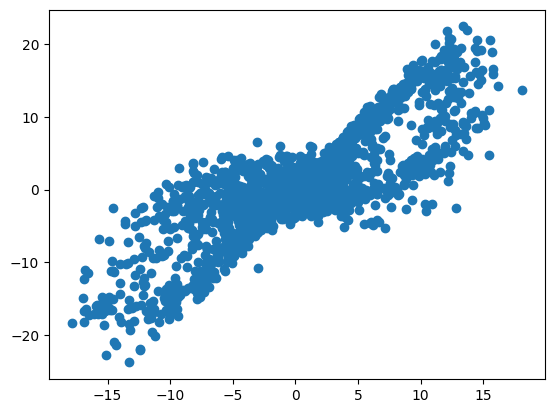

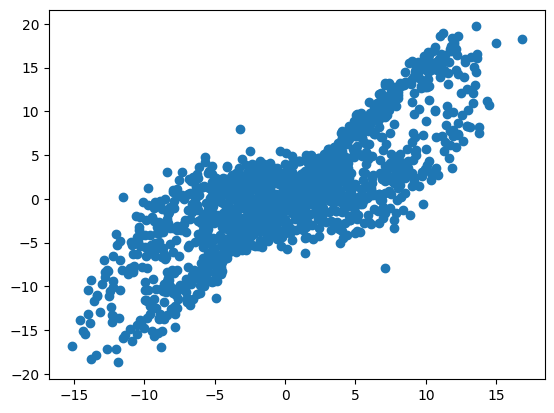

In [31]:
# Denoising the normal distribution 
samples_prior = torch.randn(N_samples*2, 3)*sigma_max # * (right_bound - left_bound) + left_bound
samples_lang = reverse_sde(scorenet, samples_prior, torch.tensor(sigma_min), torch.tensor(sigma_max)).detach().numpy() + center_values
#+ [ 0.02789861,  0.40171904, 23.31490093]#np.mean(p_samples, axis=0)

plt.scatter(samples_lang[:,0],samples_lang[:,1])
plt.show()

samples_lang2 = reverse_ode_flow(scorenet, samples_prior, torch.tensor(sigma_min), torch.tensor(sigma_max)).detach().numpy() + center_values
#+ [ 0.02789861,  0.40171904, 23.31490093]#np.mean(p_samples, axis=0)
plt.scatter(samples_lang2[:,0],samples_lang2[:,1])
plt.show()

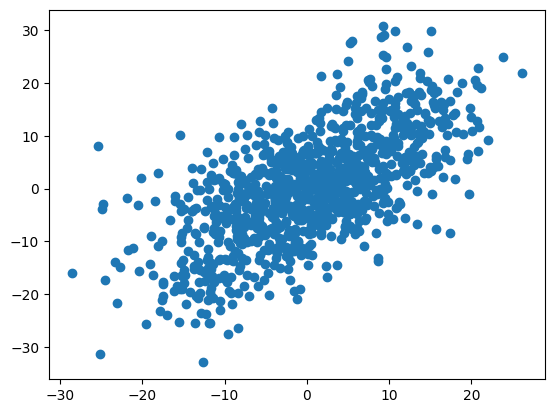

In [41]:
#plt.clf()
p_samples = toy_data.inf_train_gen(dataset, batch_size = 2000)
ve_samples = ve_dynamics(torch.tensor(p_samples).to(dtype = torch.float32),  torch.tensor(sigma_min), torch.tensor(sigma_max))


plt.scatter(ve_samples[:,0],ve_samples[:,1])
plt.show()


In [32]:
filename = f"../../assets/{dataset}/ve_sgm_{N_samples}samples.pickle"
with open(filename,"wb") as fw:
    pickle.dump([samples_lang2, samples_lang] , fw)